# Homework 7. Unsupervised learning

In this assignment, you need to apply unsupervised learning models to a breast cancer dataset. The goal is to make clustering on the gene expression of different cancer types in a breast cancer dataset. You should use K-mean, PCA and t-SNE to do the clustering. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns; sns.set()
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.cluster import adjusted_rand_score

## 1. Exploratory Data Analysis

The dataset GSE45827 was taken from kaggle (https://www.kaggle.com/brunogrisci/breast-cancer-gene-expression-cumida). It represents gene expression data from breast cancer samples curated by the Curated Microarray Database CuMiDa (http://sbcb.inf.ufrgs.br/cumida#). CuMiDa is a repository for machine learning that contains 78 handpicked cancer microarray datasets from 30,000 studies from the Gene Expression Omnibus (GEO), a public functional genomics data repository (https://www.ncbi.nlm.nih.gov/geo/). The data is already in a pre-processed and normalized format ready to be used for experimental ML approaches.

In [2]:
# load dataset and explore the first rows
df = pd.read_csv('Breast_GSE45827.csv')
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [3]:
# retrieve number of rows and columns in the dataset
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns in the breast cancer data set')

There are 151 rows and 54677 columns in the breast cancer data set


#### 1(a)
rubric={points:1}

check for missing values in dataset

Hint: use isnull() and sum()

1(a) solution

In [5]:
df.isnull().sum()

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 54677, dtype: int64

#### 1(b)
rubric={points:1}

check for unique ID identifiers

Hint: use value_counts()

1(b) solution

In [10]:
# check for unique ID identifiers
print(f"The total ids are {df['samples'].count()}, from those the unique ids are {df['samples'].value_counts()} ")

The total ids are 151, from those the unique ids are samples
84     1
85     1
87     1
90     1
91     1
      ..
230    1
233    1
236    1
237    1
238    1
Name: count, Length: 151, dtype: int64 


#### 1(c)
rubric={points:1}

check for label distribution

Hint: use value_counts()

1(c) solution

In [13]:
# check for label distribution
label_count = df['type'].value_counts()
label_count

type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of label types in breast cancer data')

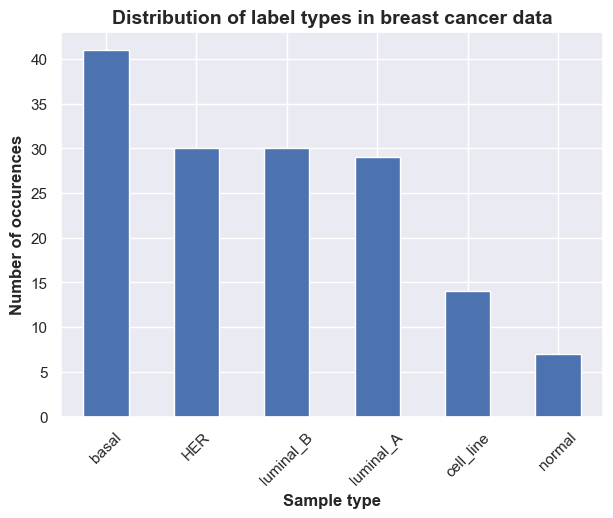

In [12]:
# visualize distribution of labels
fig = plt.figure(figsize=(7, 5))
df['type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Sample type', fontsize=12, fontweight='bold')
plt.title('Distribution of label types in breast cancer data', fontsize=14, fontweight='bold')

## 2. Data Preparation for Clustering

In [14]:
# assign labels to variable y
y = df['type']
y

0          basal
1          basal
2          basal
3          basal
4          basal
         ...    
146    luminal_B
147    luminal_B
148    luminal_B
149    luminal_B
150    luminal_B
Name: type, Length: 151, dtype: object

In [15]:
# select feature data for clustering
data = df.iloc[:,2:].values
data

array([[ 9.85003997,  8.09792735,  6.42472816, ...,  2.9666567 ,
         3.50849465,  3.30199869],
       [ 9.86135737,  8.21222225,  7.06259284, ...,  2.9347635 ,
         3.68766637,  3.06429903],
       [10.1034785 ,  8.93613685,  5.73596977, ...,  2.84768393,
         3.55059675,  3.15853522],
       ...,
       [11.02709803,  7.18087582,  6.30473602, ...,  3.0851274 ,
         3.62884807,  3.21580734],
       [10.44439499,  7.5251525 ,  5.9644598 , ...,  3.01852519,
         3.77059745,  3.10229782],
       [11.34581728,  7.3792993 ,  5.89117177, ...,  3.06158533,
         3.85752548,  3.12982746]])

Before applying clustering, we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the StandardScaler module for scaling the features individually. StandardScaler subtracts the mean from each feature and then scales to unit variance.

#### 1(d)
rubric={points:1}

1. Create a scaler using the StandardScaler module
2. fit and transform the data

1(d) solution

In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data, y)

Print the scaled data

In [17]:
scaled_data

array([[-0.79956253,  0.66184251,  0.31065541, ...,  0.51588188,
        -0.79712848,  1.26152126],
       [-0.78105222,  0.82416537,  1.30221516, ...,  0.17226811,
         0.43928775, -1.07876515],
       [-0.38504796,  1.85227675, -0.76001854, ..., -0.76591736,
        -0.50659316, -0.15095702],
       ...,
       [ 1.12558961, -0.64056402,  0.12412781, ...,  1.79227194,
         0.03339837,  0.41291911],
       [ 0.17254231, -0.15161854, -0.4048311 , ...,  1.07470717,
         1.01157301, -0.70464582],
       [ 1.64687488, -0.35876085, -0.51875725, ...,  1.53863231,
         1.61144015, -0.43360104]])

## 3. Clustering Approaches

### k-Means Clustering

Although the number of classes with 6 for the cancer subtypes is known for this dataset, perform a calculation and plotting of the cluster errors to see whether 6 is really the optimal size for k.

In [18]:
# Calculate the cluster errors for clusters from 1 to 15
cluster_range = range( 1, 20 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, n_init = 10 )
  clusters.fit(scaled_data)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:20]

,num_clusters,cluster_errors
0,1,8.255925e+06
1,2,7.576451e+06
2,3,6.963028e+06
3,4,6.593937e+06
4,5,6.274390e+06
5,6,6.063211e+06
6,7,5.997171e+06
7,8,5.843282e+06
8,9,5.769541e+06
9,10,5.731038e+06


The total sum of squared distances of every data point from respective centroid is also called inertia. Let us print the inertia value for all k values. That k at which the inertia stop to drop significantly (elbow method) will be the best k.

#### 1(e)
rubric={points:1}

1. Make the plot of num_clusters vs. cluster_errors
2. Identify the k value as the 'elbow' 

1(e) solution

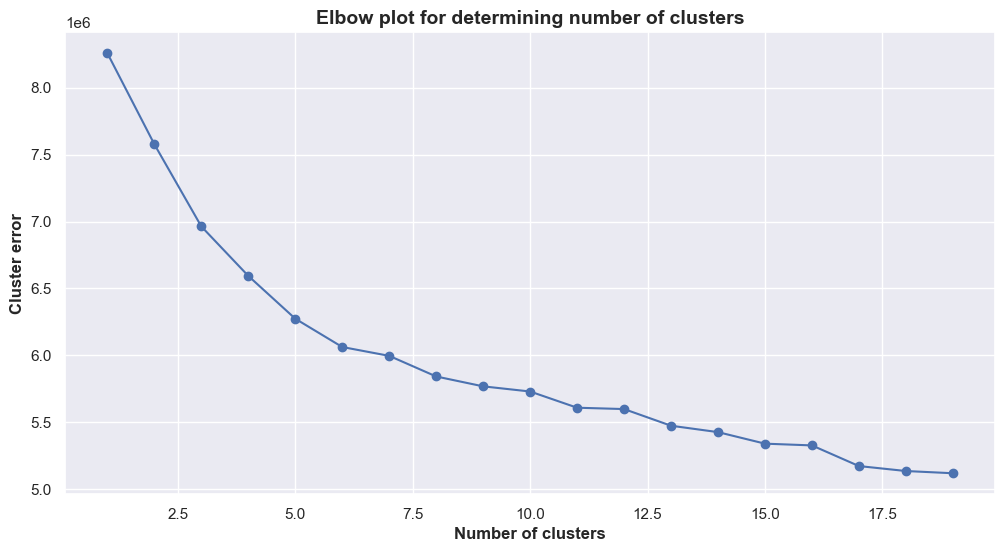

In [22]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot(cluster_range, cluster_errors, marker='o', linestyle='-')
plt.xlabel('Number of clusters', fontsize=12, fontweight='bold')
plt.ylabel('Cluster error', fontsize=12, fontweight='bold')
plt.title('Elbow plot for determining number of clusters', fontsize=14, fontweight='bold')
plt.savefig('elbowplot.png')

You should identify that k=6 is the 'elbow'.

#### 1(f)
rubric={points:1}

1. Instantiate KMeans object with n_clusters = 6
2. Predict the cluster labels for "scaled_data"

In [25]:

km = KMeans(n_clusters=6)
km.fit(scaled_data)
labels = km.labels_

In [26]:
km.cluster_centers_.shape

(6, 54675)

In [27]:
centroids = km.cluster_centers_
print(centroids)

[[-1.19734688  1.38378174  1.33255904 ... -1.04814142 -1.1147679
  -1.34615407]
 [ 0.47602167 -0.5484256   0.14374882 ...  0.02596444 -0.10689548
  -0.00891752]
 [ 0.1878817  -1.91881209 -1.58392247 ... -0.15357254 -0.47178924
   0.11033148]
 [-0.66100079  0.28306593  0.38216454 ... -0.27926988 -0.50235061
   0.30560421]
 [-0.24493035  0.75627751 -0.26288784 ...  0.15194741  0.48958024
  -0.1341356 ]
 [-0.66611736 -1.76196984 -0.69863611 ... -0.38342559 -1.06909144
   0.31585972]]


In [28]:
# print cluster labels
print(labels)

[3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 3 4 4 3 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 1 4 4 4 1 4 4 4 1 4 4 1 1 1 4 3 1 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 5 1 5 2 2 5 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [29]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(km.labels_ , columns = list(['label']))

df_labels['label'] = df_labels['label'].astype('category')

In [30]:
# Joining the label dataframe with the original data frame. 
df_labeled = df.join(df_labels)
df_labeled.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,label
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999,3
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299,3
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535,3
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665,3
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947,3


In [31]:
df_labeled['label'].value_counts()

label
1    67
4    52
3    25
2     3
5     3
0     1
Name: count, dtype: int64

### Evaluate k-means Clustering

There are several ways to evaluate a clustering. In the following, we calcuate (1) the cluster error, (2) the silhoutte plot and score as well as (3) the accuracy. Since the data set already has labels assigned to it, it is possible to calculate the amount of correct cluster assignments


(1) Calculatation of cluster error

#### 1(g)
rubric={points:1}

1. print the cluster error defined as inertia_ of a KMEAN object.

1(g) solution

In [32]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 6732122.72


(2) Calculation of accuracy score. Since the k-means algorithm doesn´t have any knowledge on the true cluster labels, the permutations need to be found before comparing to the true labels.

In [33]:
def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

In [34]:
permutation = find_permutation(6, y, km.labels_)
print(permutation)

TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

#### 1(h)
rubric={points:1}

calculate the prediction accuracy of labels 
Hint: use accuracy_score()

In [47]:
new_labels = [ permutation[label] for label in km.labels_]   # permute the labels
print("Accuracy score is", ____)

Accuracy score is 0.6225165562913907


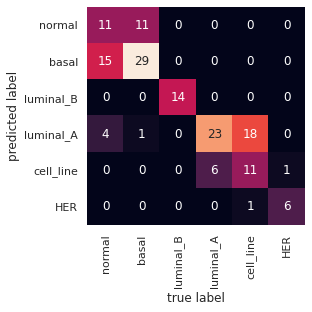

In [48]:
# plot confusion matrix
mat = confusion_matrix(y, new_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=permutation,
            yticklabels=permutation)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('confustion_matrix_1')

(3) Create silhouette plot and calculate silhouette score

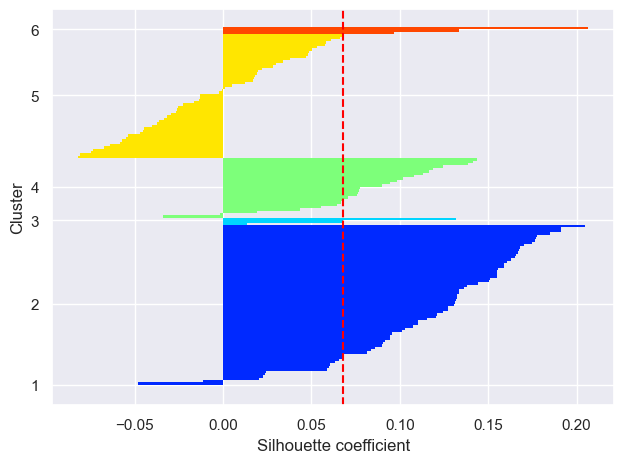

In [35]:
# create silhoutte plot
cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(scaled_data,
                                      labels,
                                      metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
     c_silhouette_vals = silhouette_vals[labels == c]
     c_silhouette_vals.sort()
     y_ax_upper += len(c_silhouette_vals)
     color = cm.jet(float(i) / n_clusters)
     plt.barh(range(y_ax_lower, y_ax_upper),
              c_silhouette_vals,
              height=1.0,
              edgecolor='none',
              color=color)
     yticks.append((y_ax_lower + y_ax_upper) / 2.)
     y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
             color="red",
             linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
#plt.show()
plt.savefig('silhoutte_plot_1.png')

In [36]:
kmeansSilhouette_Score = metrics.silhouette_score(data, labels, metric='euclidean')

In [37]:
print(kmeansSilhouette_Score)

0.07479849693012627


In [38]:
rand_index = adjusted_rand_score(labels_true = y, labels_pred = labels)
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.33


### Apply PCA to data before clustering

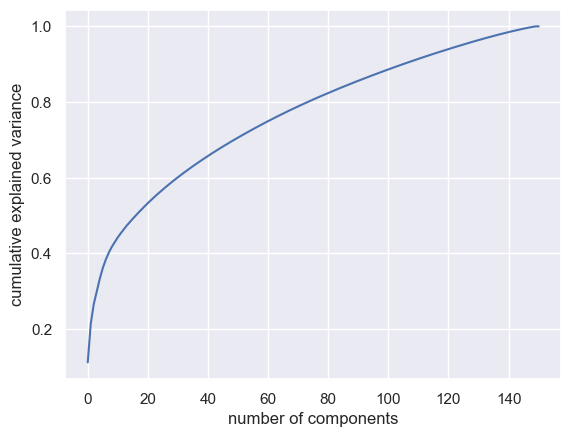

In [39]:
# In order to find the number of dimensions explaining most of the variety in the data, plot cumulative explained variance
pca_plot = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#### 1(i)
rubric={points:1}

Based on the PCA plot above, how many principal components are needed to explain 90% of data? 

1(i) answer: About 100

### Apply t-SNE

PCA didn´t seem to be a good approach as it would need 100 components to explain most of the data. Try t-SNE instead on original data.

In [40]:
tsne = TSNE(random_state=0)

In [41]:
tsne_result = tsne.fit_transform(data)

In [42]:
xi = tsne_result[:, 0]
yi = tsne_result[:, 1]

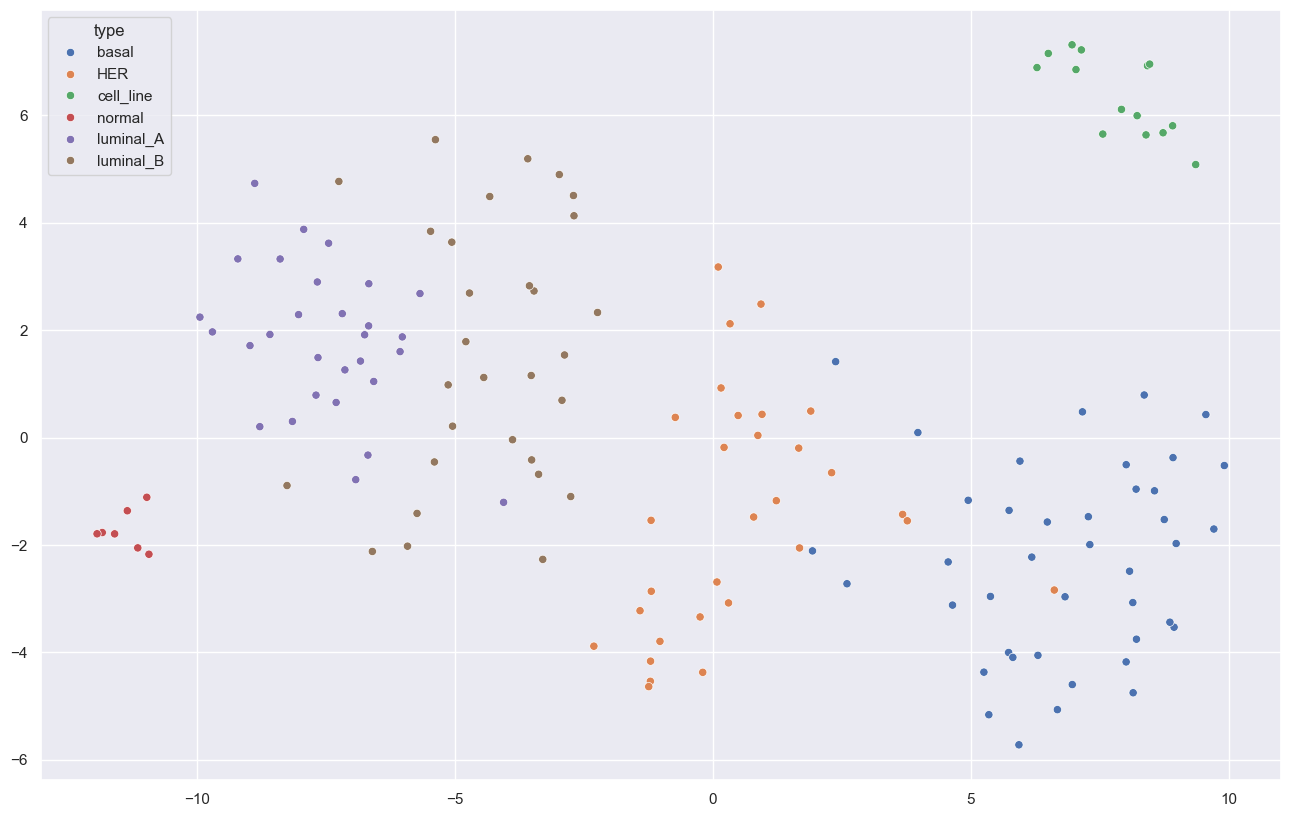

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xi, y=yi,
    hue=y,
    legend="full",
    alpha=1
)
plt.savefig('t-SNE_plot.png')

#### 1(j)
rubric={points:1}

Try t-SNE on scaled data. Hint: please follow the example above

In [45]:
tsne_scaled = TSNE(random_state=0)

In [46]:
tsne_result_scaled = tsne_scaled.fit_transform(scaled_data)

In [47]:
xi_scaled = tsne_result_scaled[:, 0]
yi_scaled = tsne_result_scaled[:, 1]

<Axes: >

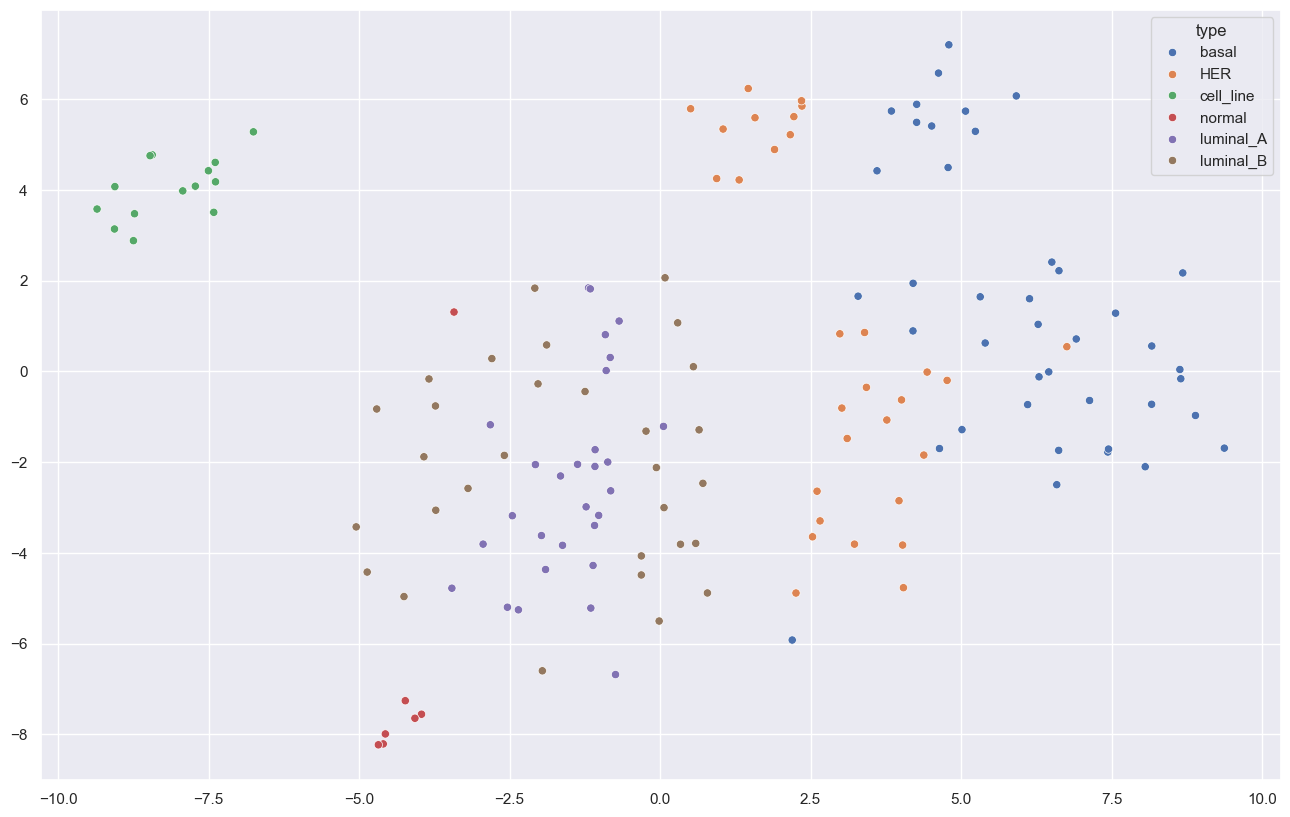

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xi_scaled, y=yi_scaled,
    hue=y,
    legend="full",
    alpha=1
)

Does t-SNE do better on original data or scaled data?

Your answer: On original data

Run k-means algorithm on data after t-SNE with original data. t-SNE on scaled data visually doesn´t separate the clusters as well as with the original data.

In [49]:
km_tsne = KMeans(n_clusters = 6, random_state=0)

In [50]:
# predict the cluster labels
labels_tsne = km_tsne.fit_predict(tsne_result)

In [51]:
labels_tsne.size

151

In [52]:
labels_tsne

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 2, 2, 2, 2, 5, 5, 2, 2,
       5, 5, 2, 2, 3, 5, 2, 5, 2, 2, 2, 2, 2, 5, 3, 5, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       2, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 4, 4,
       4, 4, 3, 4, 4, 1, 1, 1, 4, 1, 1, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 3, 1, 3, 1, 4, 1, 1, 1, 1],
      dtype=int32)

In [53]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels_tsne = pd.DataFrame(km_tsne.labels_ , columns = list(['label']))
df_labels_tsne['label'] = df_labels_tsne['label'].astype('category')
df_labels_tsne.head()

,label
0,5
1,5
2,5
3,5
4,5


In [54]:
df_labels_tsne['label'].value_counts()

label
1    39
3    35
2    22
4    21
5    20
0    14
Name: count, dtype: int64

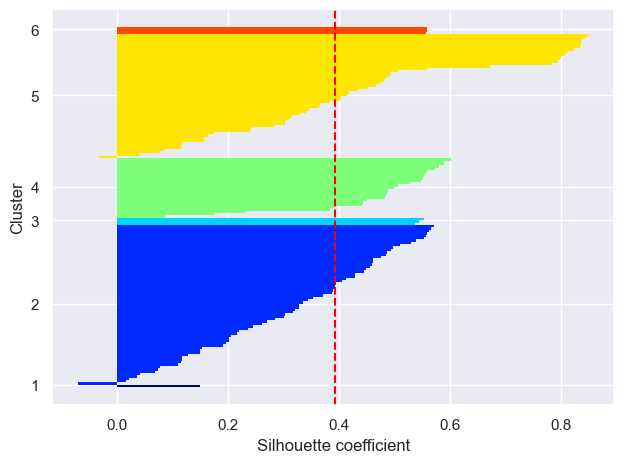

In [55]:
# silhouette plot
cluster_labels = np.unique(labels_tsne)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(tsne_result,
                                      labels_tsne,
                                      metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
     c_silhouette_vals = silhouette_vals[labels == c]
     c_silhouette_vals.sort()
     y_ax_upper += len(c_silhouette_vals)
     color = cm.jet(float(i) / n_clusters)
     plt.barh(range(y_ax_lower, y_ax_upper),
              c_silhouette_vals,
              height=1.0,
              edgecolor='none',
              color=color)
     yticks.append((y_ax_lower + y_ax_upper) / 2.)
     y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
             color="red",
             linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
#plt.show()
plt.savefig('silhoutte_plot_2.png')

In [56]:
kmeansSilhouette_Score = metrics.silhouette_score(tsne_result, labels_tsne, metric='euclidean')
kmeansSilhouette_Score

np.float32(0.39328706)

In [57]:
permutation = find_permutation(6, y, km_tsne.labels_)
print(permutation)

TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

In [73]:
new_labels = [ permutation[label] for label in km_tsne.labels_]   # permute the labels
print("Accuracy score is", accuracy_score(y, new_labels))

Accuracy score is 0.8675496688741722


This dataset has "ground truth" cell type labels available. We can use these to assess our cluster labels a bit more rigorously using the adjusted Rand index. This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance.

In [58]:
rand_index = adjusted_rand_score(labels_true = y, labels_pred = labels_tsne)
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.49


### UMAP (for your own practice and learning)

In [2]:
import umap
import numba.targets

ModuleNotFoundError: No module named 'numba.targets'

In [7]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(data)

AttributeError: module 'umap' has no attribute 'UMAP'

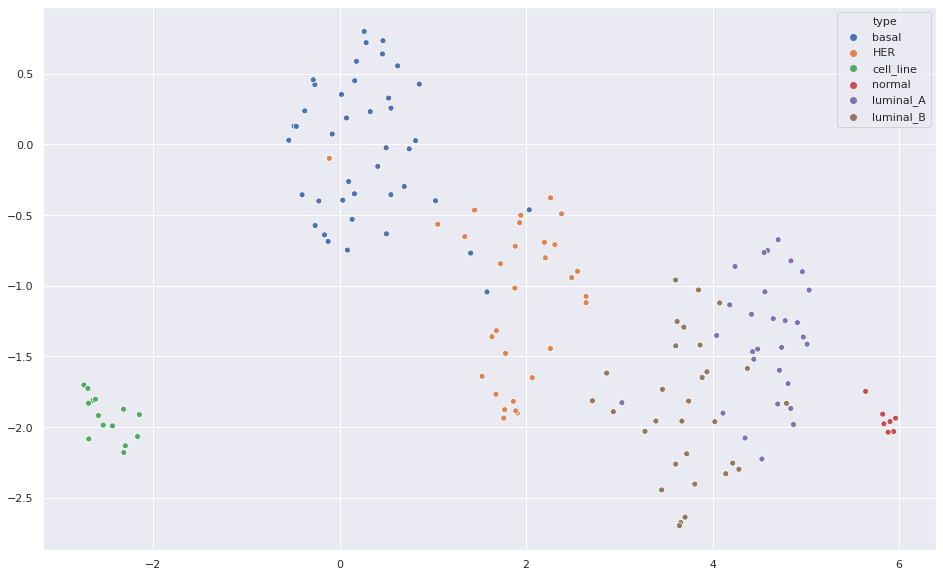

In [77]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=clusterable_embedding[:, 0], y=clusterable_embedding[:, 1],
    hue=y,
    legend="full",
    alpha=1
)
plt.savefig('UMAP_plot.png')

Perform k-means clustering after UMAP embedding

In [78]:
km_umap = KMeans(n_clusters = 6)

In [79]:
# predict the cluster labels
labels_umap = km_umap.fit_predict(clusterable_embedding)

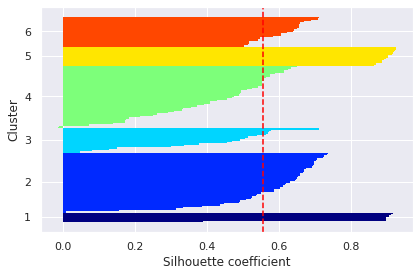

In [80]:
# silhouette plot
cluster_labels = np.unique(labels_umap)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(clusterable_embedding,
                                      labels_umap,
                                      metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
     c_silhouette_vals = silhouette_vals[labels == c]
     c_silhouette_vals.sort()
     y_ax_upper += len(c_silhouette_vals)
     color = cm.jet(float(i) / n_clusters)
     plt.barh(range(y_ax_lower, y_ax_upper),
              c_silhouette_vals,
              height=1.0,
              edgecolor='none',
              color=color)
     yticks.append((y_ax_lower + y_ax_upper) / 2.)
     y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
             color="red",
             linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
#plt.show()
plt.savefig('silhoutte_plot_3.png')

In [81]:
kmeansSilhouette_Score = metrics.silhouette_score(clusterable_embedding, labels_umap, metric='euclidean')
kmeansSilhouette_Score

0.5552227

In [82]:
permutation = find_permutation(6, y, km_umap.labels_)
print(permutation)

['luminal_B', 'basal', 'normal', 'cell_line', 'HER', 'luminal_A']


In [83]:
new_labels = [ permutation[label] for label in km_umap.labels_]   # permute the labels
print("Accuracy score is", accuracy_score(y, new_labels))

Accuracy score is 0.9139072847682119


In [84]:
rand_index = adjusted_rand_score(labels_true = y, labels_pred = labels_umap)
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.79
